In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/storage/camvid/codes.txt'),
 PosixPath('/storage/camvid/valid.txt'),
 PosixPath('/storage/camvid/images'),
 PosixPath('/storage/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/camvid/images/0006R0_f03750.png'),
 PosixPath('/storage/camvid/images/Seq05VD_f01320.png'),
 PosixPath('/storage/camvid/images/Seq05VD_f03510.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage/camvid/labels/Seq05VD_f03990_P.png'),
 PosixPath('/storage/camvid/labels/0016E5_08017_P.png'),
 PosixPath('/storage/camvid/labels/Seq05VD_f00750_P.png')]

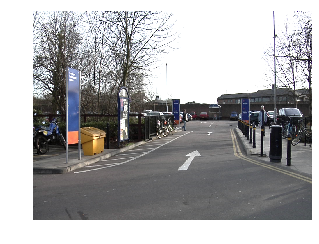

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

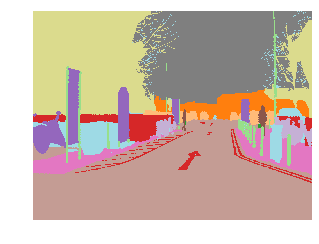

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 30, 21, 21],
          [26, 26, 26,  ..., 30, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
size = src_size//2
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 8114MB of GPU RAM free


In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

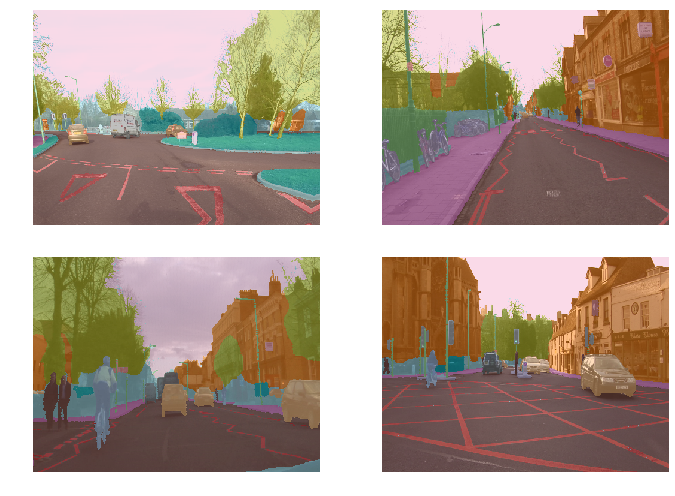

In [15]:
data.show_batch(2, figsize=(10,7))

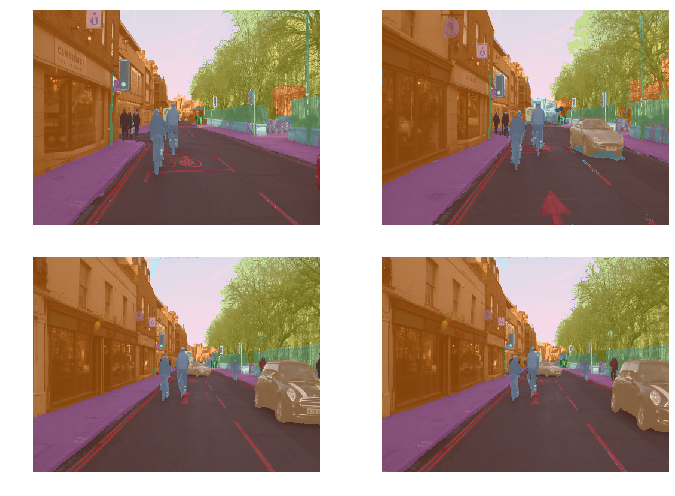

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid

In [19]:
wd=1e-2

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


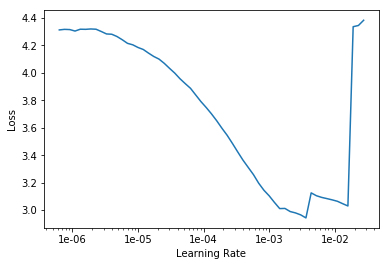

In [22]:
lr_find(learn)
learn.recorder.plot()

In [29]:
lr=5e-4

In [25]:
learn.fit_one_cycle(9, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.762967,0.626403,0.843885,00:56
1,0.681364,0.553982,0.854570,00:56
2,0.612236,0.530567,0.854817,00:56
3,0.583936,0.442361,0.882887,00:57
4,0.522215,0.447239,0.868105,00:56
5,0.501587,0.420767,0.884907,00:56
6,0.474286,0.440008,0.879860,00:56
7,0.440264,0.366543,0.896336,00:57
8,0.389805,0.312365,0.911992,00:56


In [26]:
learn.save('stage-1');

In [27]:
learn.load('stage-1');

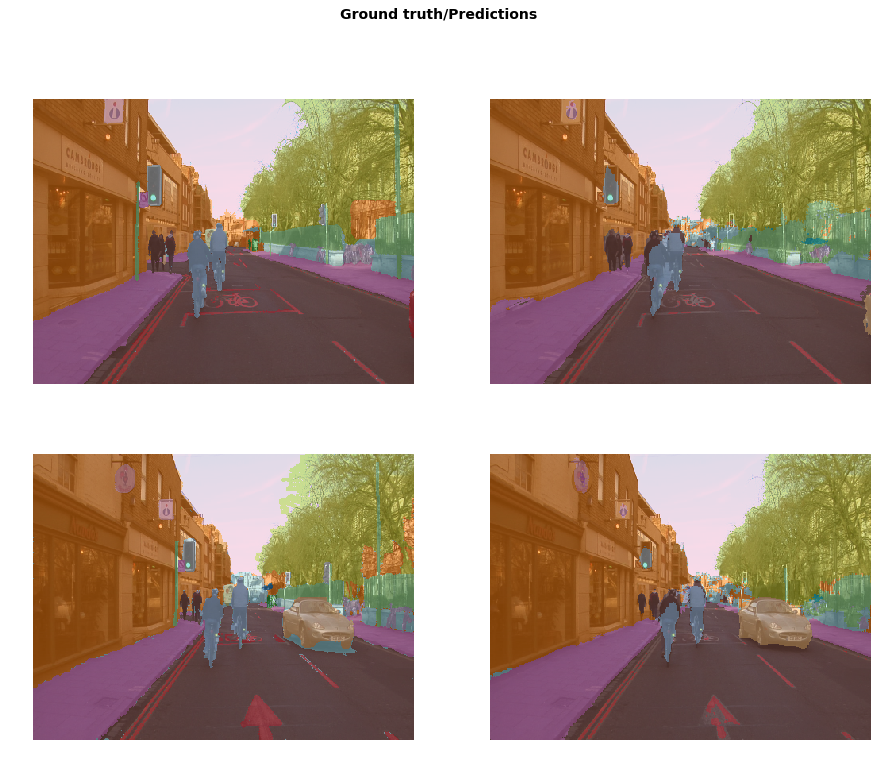

In [28]:
learn.show_results(rows=2, figsize=(15,12))

In [29]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


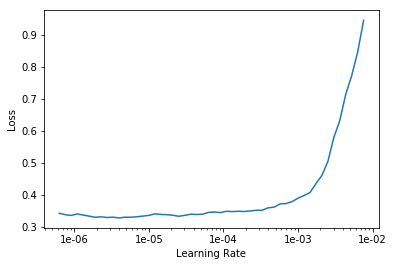

In [30]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.339470,0.307285,0.912557,00:59
1,0.334445,0.299482,0.914417,00:59
2,0.328531,0.299098,0.914014,00:59
3,0.318294,0.311380,0.909628,00:59
4,0.316704,0.300157,0.914622,00:59
5,0.309277,0.327984,0.904513,00:59
6,0.303777,0.286272,0.916796,00:59
7,0.293037,0.289578,0.915300,00:59
8,0.289546,0.317809,0.906316,00:59
9,0.274977,0.290783,0.915341,00:59


In [33]:
learn.save('stage-2');

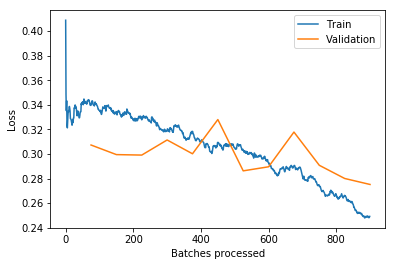

In [34]:
learn.recorder.plot_losses();

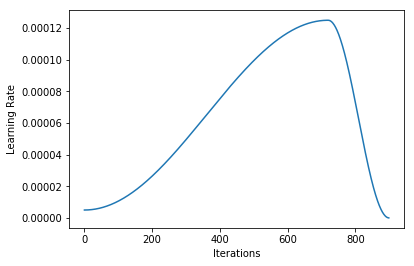

In [35]:
learn.recorder.plot_lr();

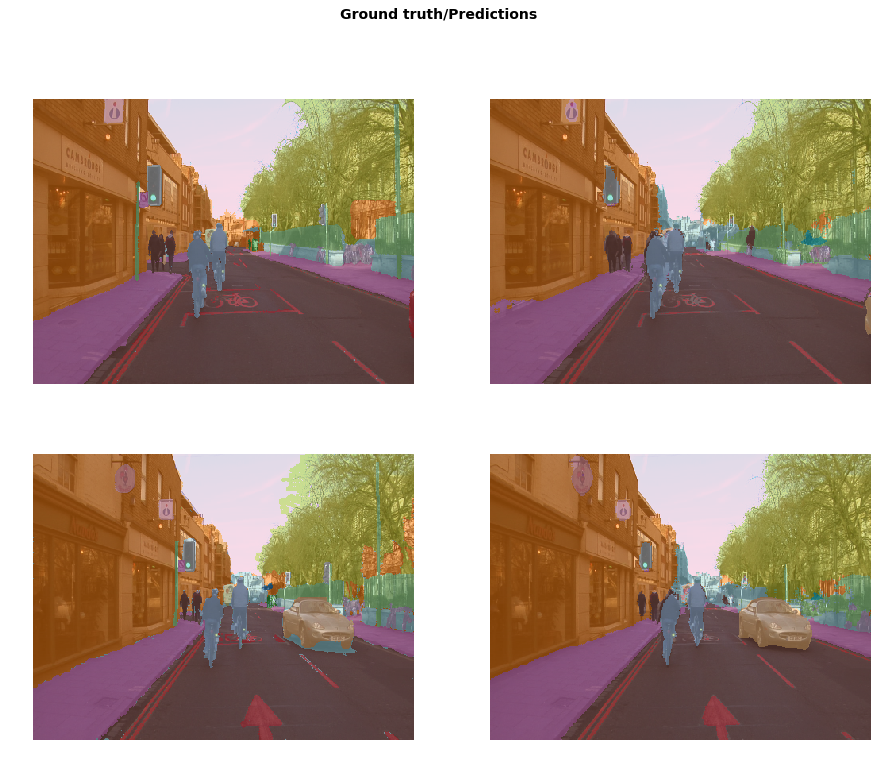

In [36]:
learn.show_results(rows=2, figsize=(15,12))

# GO BIG

In [21]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 7753MB of GPU RAM free


In [22]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [41]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


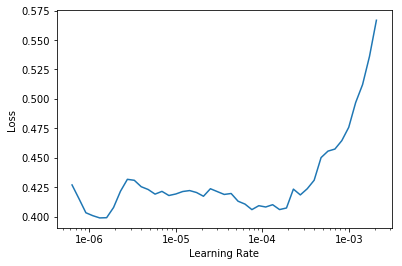

In [42]:
lr_find(learn)
learn.recorder.plot()

In [43]:
lr=2e-5

In [44]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.413633,0.352173,0.902518,04:09
1,0.376117,0.332117,0.906365,04:05
2,0.368806,0.318919,0.909489,04:05
3,0.347597,0.311856,0.910893,04:05
4,0.332459,0.293290,0.914246,04:05
5,0.327779,0.297632,0.913497,04:05
6,0.312665,0.301605,0.911718,04:05
7,0.301202,0.298889,0.913346,04:06
8,0.295603,0.276995,0.918715,04:06
9,0.285202,0.286978,0.916925,04:06


In [45]:
learn.save('stage-1-big');

In [24]:
learn.load('stage-1-big');

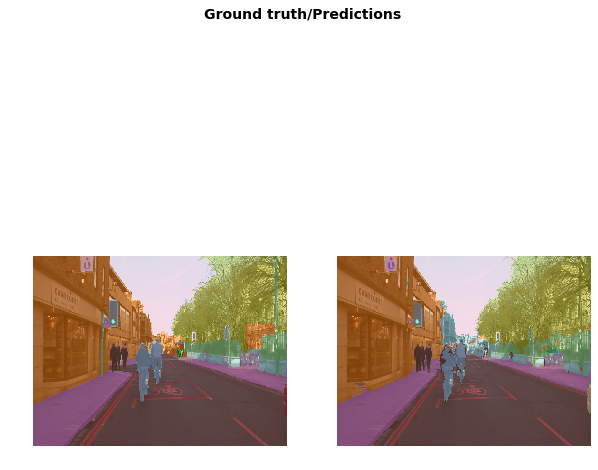

In [25]:
learn.show_results(rows=3, figsize=(10,10));

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


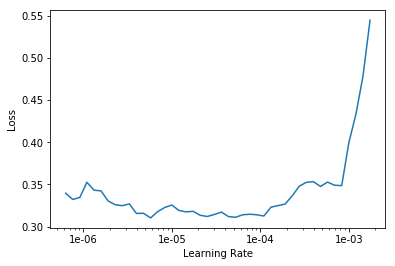

In [27]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lrs = slice(1e-5,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.303496,0.292907,0.914328,10:40
1,0.288453,0.294079,0.917561,10:41
2,0.323348,0.265595,0.921311,10:41
3,0.287670,0.293865,0.917533,10:41
4,0.226564,0.247651,0.929733,10:41
5,0.225567,0.292111,0.918503,10:41
6,0.206650,0.252995,0.926796,10:41


In [ ]:
learn.save('stage-2-big');

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10));